Using device: mps
Files already downloaded and verified
Files already downloaded and verified
Train size :  50000
Validation size :  10000
torch.Size([64, 3, 32, 32])
torch.Size([64])


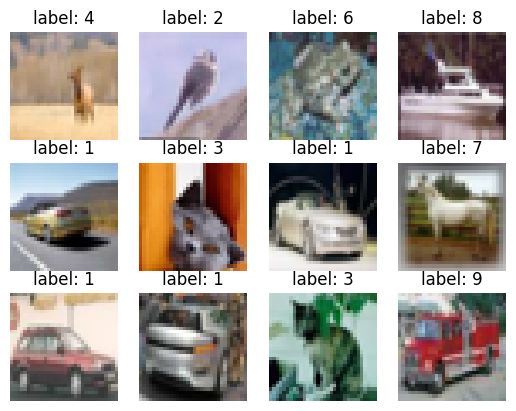

Total trainable parameters:  579402
Epoch: 1/20  Training loss: 2.2164  Validation loss: 2.0645  Train accuracy: 0.2155  Validation accuracy: 0.2716  Epoch time: 43.63 seconds
Epoch: 2/20  Training loss: 1.9700  Validation loss: 1.8779  Train accuracy: 0.2988  Validation accuracy: 0.3333  Epoch time: 40.67 seconds
Epoch: 3/20  Training loss: 1.8303  Validation loss: 1.7580  Train accuracy: 0.3510  Validation accuracy: 0.3758  Epoch time: 42.17 seconds
Epoch: 4/20  Training loss: 1.7090  Validation loss: 1.6423  Train accuracy: 0.3925  Validation accuracy: 0.4117  Epoch time: 42.49 seconds
Epoch: 5/20  Training loss: 1.6012  Validation loss: 1.5398  Train accuracy: 0.4294  Validation accuracy: 0.4502  Epoch time: 42.17 seconds
Epoch: 6/20  Training loss: 1.5166  Validation loss: 1.5151  Train accuracy: 0.4584  Validation accuracy: 0.4619  Epoch time: 41.57 seconds
Epoch: 7/20  Training loss: 1.4479  Validation loss: 1.4261  Train accuracy: 0.4819  Validation accuracy: 0.4926  Epoch time

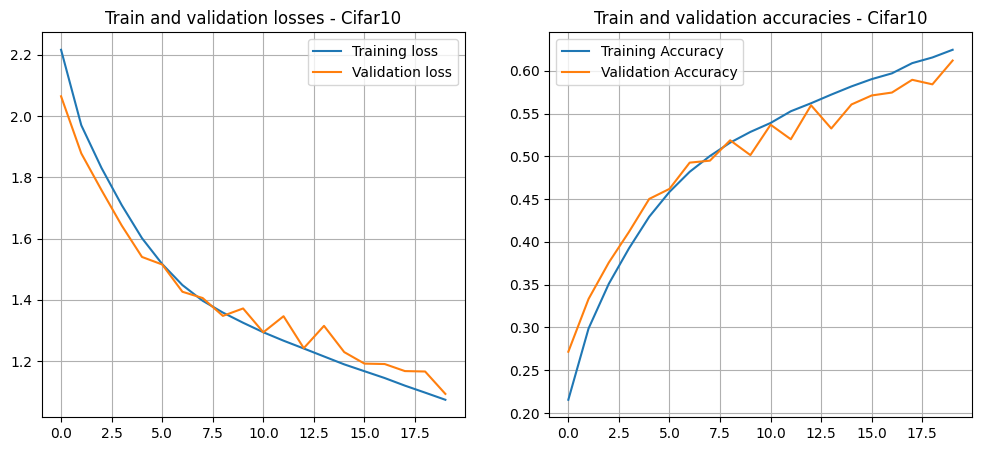

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import time
import matplotlib.pyplot as plt

# Activer MPS si disponible
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
print(f"Using device: {device}")

# Define transform to normalize data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download and load the training data and the validation (test) data
train_set = datasets.CIFAR10('DATA_CIFAR/', download=True, train=True, transform=transform)
trainLoader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

validation_set = datasets.CIFAR10('DATA_CIFAR/', download=True, train=False, transform=transform)
validationLoader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=True)

# Show the training size, test size, number of class
print("Train size : ", len(train_set))
print("Validation size : ", len(validation_set))

# Check the size of the image tensors and label tensors
training_data = enumerate(trainLoader)
batch_idx, (images, labels) = next(training_data)

print(images.shape)  # The size of the image
print(labels.shape)  # The size of the labels

# Display some image samples using matplotlib.pyplot
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow((images[i] / 2 + 0.5).permute(1, 2, 0).numpy())  # (img/2+0.5) is just to unnormalize the image
    plt.axis('off')
    plt.title("label: " + str(labels[i].numpy().squeeze()))

plt.show()

class CNN_cifar(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 5, 1, 2)  # Size of feature maps = 32x32x32
        self.pool = nn.MaxPool2d(2, 2)  # Size = 16x16x32
        self.conv2 = nn.Conv2d(32, 64, 5, 1, 2)  # Size = 16x16x64
        self.pool = nn.MaxPool2d(2, 2)  # Size = 8x8x64
        self.fc1 = nn.Linear(64 * 8 * 8, 128)  # Different from Mnist since the size of image is 32x32x3
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNN_cifar()
model.to(device)

# Print number of total trainable parameters
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total trainable parameters: ", total_trainable_params)

optimizer = optim.SGD(model.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()

epochs = 20
train_loss, val_loss = [], []
accuracy_total_train, accuracy_total_val = [], []
training_times = []

for epoch in range(epochs):
    start_time = time.time()

    total_train_loss = 0
    total_val_loss = 0

    model.train()

    total = 0

    # Training our model
    for idx, (image, label) in enumerate(trainLoader):
        image, label = image.to(device), label.to(device)

        optimizer.zero_grad()

        pred = model(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

    accuracy_train = total / len(train_set)
    accuracy_total_train.append(accuracy_train)

    total_train_loss = total_train_loss / (idx + 1)
    train_loss.append(total_train_loss)

    # Validating our model
    model.eval()
    total = 0
    for idx, (image, label) in enumerate(validationLoader):
        image, label = image.to(device), label.to(device)
        pred = model(image)
        loss = criterion(pred, label)
        total_val_loss += loss.item()

        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

    accuracy_val = total / len(validation_set)
    accuracy_total_val.append(accuracy_val)

    total_val_loss = total_val_loss / (idx + 1)
    val_loss.append(total_val_loss)

    end_time = time.time()
    epoch_time = end_time - start_time
    training_times.append(epoch_time)

    print(f"Epoch: {epoch+1}/{epochs}  "
          f"Training loss: {total_train_loss:.4f}  "
          f"Validation loss: {total_val_loss:.4f}  "
          f"Train accuracy: {accuracy_train:.4f}  "
          f"Validation accuracy: {accuracy_val:.4f}  "
          f"Epoch time: {epoch_time:.2f} seconds")

# Print total training time
total_training_time = sum(training_times)
print(f"Total training time: {total_training_time:.2f} seconds")

# Plot the loss curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.grid()
plt.title('Train and validation losses - Cifar10')

# Plot the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(accuracy_total_train, label='Training Accuracy')
plt.plot(accuracy_total_val, label='Validation Accuracy')
plt.legend()
plt.grid()
plt.title('Train and validation accuracies - Cifar10')
plt.show()

## Fine tuning avec Resnet 50 

MPS (Metal Performance Shaders) trouvé et utilisé.
Network before modifying conv1:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (do

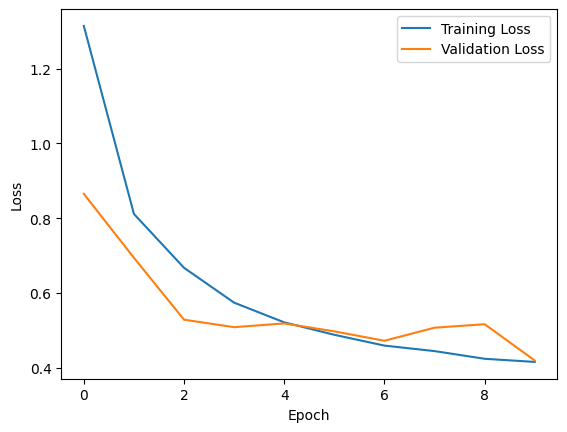

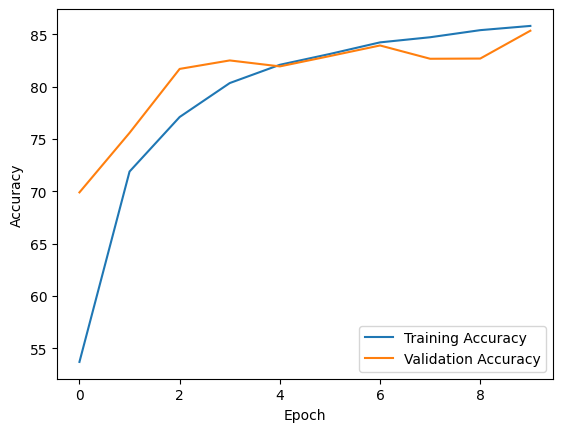

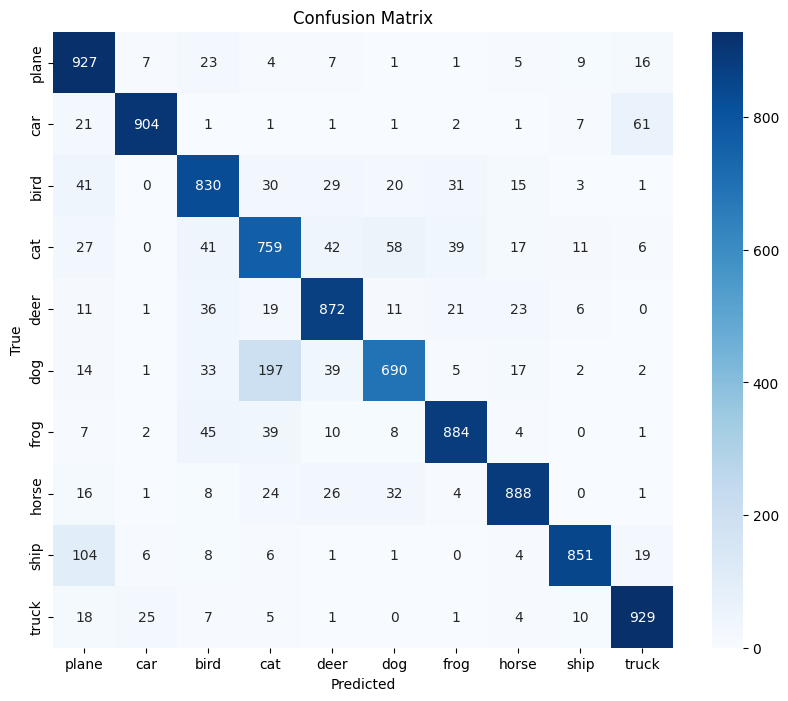

In [27]:
import torch

# Vérification du dispositif disponible
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS (Metal Performance Shaders) trouvé et utilisé.")
else:
    print("MPS non disponible, le script se termine.")
    exit()

import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import random
import time
from sklearn.metrics import confusion_matrix
import seaborn as sns

def load_dataset():
    dataset_path = './data/cifar10'

    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    trainset = torchvision.datasets.CIFAR10(root=dataset_path, train=True,
                                            download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                              shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(root=dataset_path, train=False,
                                           download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                             shuffle=False, num_workers=2)

    classes = ('plane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck')

    return trainset, trainloader, testset, testloader, classes

def train(model, trainloader, criterion, optimizer, device):
    train_loss = 0.0
    train_total = 0
    train_correct = 0

    model.train()

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(trainloader.dataset)
    train_accuracy = 100.0 * train_correct / train_total

    return model, train_loss, train_accuracy

def test(model, testloader, criterion, device):
    test_loss = 0.0
    test_total = 0
    test_correct = 0

    all_labels = []
    all_predictions = []

    model.eval()

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    test_loss = test_loss / len(testloader.dataset)
    test_accuracy = 100.0 * test_correct / test_total

    return test_loss, test_accuracy, all_labels, all_predictions

def train_epochs(model, trainloader, testloader, criterion, optimizer, scheduler, device, num_epochs, save_interval=5):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    total_training_time = 0

    for epoch in range(num_epochs):
        start_time = time.time()
        print(f'Epoch {epoch+1}/{num_epochs}')
        model, train_loss, train_accuracy = train(model, trainloader, criterion, optimizer, device)
        test_loss, test_accuracy, all_labels, all_predictions = test(model, testloader, criterion, device)

        end_time = time.time()
        epoch_time = end_time - start_time
        total_training_time += epoch_time

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(f'Validation Loss: {test_loss:.4f}, Validation Accuracy: {test_accuracy:.2f}%')
        print(f'Epoch: {epoch+1}/{num_epochs}  Training loss: {train_loss:.4f}  Validation loss: {test_loss:.4f}  Train accuracy: {train_accuracy:.4f}  Validation accuracy: {test_accuracy:.4f}  Epoch time: {epoch_time:.2f} seconds\n')

        scheduler.step(test_loss)

        if (epoch + 1) % save_interval == 0:
            torch.save(model.state_dict(), f'resnet50_cifar10_{epoch+1}.pth')
            checkpoint = {
                'epoch': epoch + 1,
                'train_losses': train_losses,
                'train_accuracies': train_accuracies,
                'test_losses': test_losses,
                'test_accuracies': test_accuracies,
                'classes': classes
            }
            torch.save(checkpoint, f'resnet50_cifar10_variables_{epoch+1}.pth')

    print(f'Total training time: {total_training_time:.2f} seconds')

    return model, train_losses, train_accuracies, test_losses, test_accuracies, all_labels, all_predictions

def plot_loss(train_losses, test_losses):
    plt.figure()
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
    plt.plot(range(len(test_losses)), test_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('loss_plot.png')
    plt.show()

def plot_accuracy(train_accuracies, test_accuracies):
    plt.figure()
    plt.plot(range(len(train_accuracies)), train_accuracies, label='Training Accuracy')
    plt.plot(range(len(test_accuracies)), test_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('accuracy_plot.png')
    plt.show()

def plot_confusion_matrix(true_labels, pred_labels, classes):
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    plt.show()

if __name__ == '__main__':
    train_model = True

    random_seed = 42
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    random.seed(random_seed)

    num_classes = 10

    model = models.resnet50(pretrained=True)
    print("Network before modifying conv1:")
    print(model)

    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    print("Network after modifying conv1:")
    print(model)

    model = model.to(device)

    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Total trainable parameters: {total_params}')

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

    trainset, trainloader, testset, testloader, classes = load_dataset()

    if train_model:
        num_epochs = 10
        save_interval = 5
        model, train_losses, train_accuracies, test_losses, test_accuracies, all_labels, all_predictions = train_epochs(
            model, trainloader, testloader, criterion, optimizer, scheduler, device,
            num_epochs, save_interval)

        torch.save(model.state_dict(), f'resnet50_cifar10_final_model_epochs_{num_epochs}.pth')

        plot_loss(train_losses, test_losses)
        plot_accuracy(train_accuracies, test_accuracies)
        plot_confusion_matrix(all_labels, all_predictions, classes)
    else:
        model.load_state_dict(torch.load('resnet50_cifar10_final_model_epochs_50.pth'))
        checkpoint = torch.load("resnet50_cifar10_variables.pth")
        epoch = checkpoint['epoch']
        train_losses = checkpoint['train_losses']
        train_accuracies = checkpoint['train_accuracies']
        test_losses = checkpoint['test_losses']
        test_accuracies = checkpoint['test_accuracies']
        classes = checkpoint['classes']
        model.to(device)
        model.eval()

        plot_image(testset, model, classes, device)

##  fine tuning du vgg 16

Using device: mps
Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Loss: 0.9878289387049273, Accuracy: 65.028%
Validation Loss: 0.7002756667137146, Validation Accuracy: 76.04%
Epoch 2, Loss: 0.6219685208004759, Accuracy: 78.82%
Validation Loss: 0.6017502781748771, Validation Accuracy: 79.07%
Epoch 3, Loss: 0.5242088985869952, Accuracy: 81.936%
Validation Loss: 0.5189137023687362, Validation Accuracy: 82.2%
Epoch 4, Loss: 0.46515305591818623, Accuracy: 83.952%
Validation Loss: 0.482798862606287, Validation Accuracy: 82.86%
Epoch 5, Loss: 0.4241895768267419, Accuracy: 85.348%
Validation Loss: 0.45452185317873955, Validation Accuracy: 84.3%
Epoch 6, Loss: 0.3894797278868268, Accuracy: 86.628%
Validation Loss: 0.4279596945643425, Validation Accuracy: 85.8%
Epoch 7, Loss: 0.3569580563498885, Accuracy: 87.518%
Validation Loss: 0.44802543610334394, Validation Accuracy: 85.13%
Epoch 8, Loss: 0.33394746333741776, Accuracy: 88.606%
Validation Loss: 0.407138754

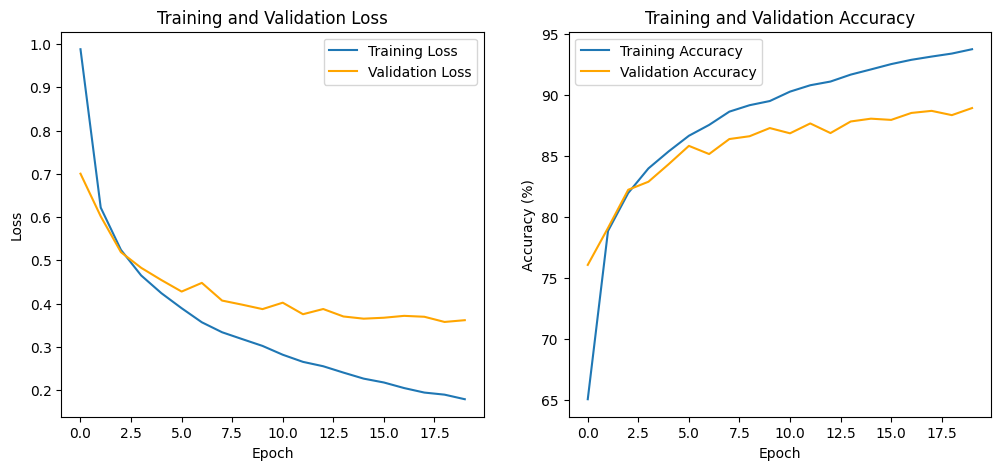

                 Model  Number of trainable params  Test accuracy  \
0  VGG16 (Fine Tuning)                   134301514           88.9   

   Training time per epoch (s)  
0                   108.177231  


In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import pandas as pd

# Activer MPS si disponible
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
print(f"Using device: {device}")

# Charger VGG16 pré-entraîné pour le fine-tuning
vgg16 = torchvision.models.vgg16(pretrained=True)
vgg16.to(device)

# Modifier la couche finale pour qu'elle s'adapte aux classes CIFAR-10
num_ftrs = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(num_ftrs, 10)
vgg16.classifier[6].to(device)

# Préparer les données CIFAR-10
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Définir les fonctions d'entraînement et d'évaluation
def train_model_with_evaluation(model, trainloader, testloader, criterion, optimizer, epochs=10):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    training_times = []
    for epoch in range(epochs):
        model.train()
        start_time = time.time()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        avg_loss = running_loss / len(trainloader)
        train_losses.append(avg_loss)
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)
        print(f"Epoch {epoch+1}, Loss: {avg_loss}, Accuracy: {train_accuracy}%")
        
        val_loss, val_accuracy = evaluate_model(model, testloader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        end_time = time.time()
        epoch_time = end_time - start_time
        training_times.append(epoch_time)

    return train_losses, val_losses, train_accuracies, val_accuracies, training_times

def evaluate_model(model, testloader, criterion):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_loss = running_loss / len(testloader)
    accuracy = 100 * correct / total
    print(f"Validation Loss: {avg_loss}, Validation Accuracy: {accuracy}%")
    return avg_loss, accuracy

# Entraîner et évaluer le modèle
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
train_losses, val_losses, train_accuracies, val_accuracies, training_times =train_model_with_evaluation(
    vgg16, trainloader, testloader, criterion, optimizer, epochs=20)

# Tracer les courbes de perte et de précision
plt.figure(figsize=(12, 5))

# Courbe de perte
plt.subplot(1, 2, 1)
plt.title("Training and Validation Loss")
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss", color='orange')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Courbe de précision
plt.subplot(1, 2, 2)
plt.title("Training and Validation Accuracy")
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy", color='orange')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.show()

# Afficher les résultats sous forme de tableaux
num_trainable_params = sum(p.numel() for p in vgg16.parameters() if p.requires_grad)
avg_train_time_per_epoch = sum(training_times) / len(training_times)
test_accuracy = val_accuracies[-1]

data = {
    "Model": ["VGG16 (Fine Tuning)"],
    "Number of trainable params": [num_trainable_params],
    "Test accuracy": [test_accuracy],
    "Training time per epoch (s)": [avg_train_time_per_epoch]
}

df = pd.DataFrame(data)
print(df)

# feacture extraction 

MPS (Metal Performance Shaders) trouvé et utilisé.


/Users/usmanalfayed/miniforge3/envs/myenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/usmanalfayed/miniforge3/envs/myenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Loss: 2.0973673281462295, Accuracy: 25.77%, Trainable Params: 20490
Validation Loss: 1.9755290842056275, Validation Accuracy: 34.84%
Time for epoch 1: 57.78 seconds
Epoch 2, Loss: 1.8784484497421539, Accuracy: 36.042%, Trainable Params: 20490
Validation Loss: 1.8620841801166534, Validation Accuracy: 39.03%
Time for epoch 2: 57.25 seconds
Epoch 3, Loss: 1.8046366052554392, Accuracy: 38.258%, Trainable Params: 20490
Validation Loss: 1.7715885734558106, Validation Accuracy: 41.12%
Time for epoch 3: 57.21 seconds
Epoch 4, Loss: 1.7724176956259685, Accuracy: 39.14%, Trainable Params: 20490
Validation Loss: 1.8004317677021027, Validation Accuracy: 41.11%
Time for epoch 4: 57.48 seconds
Epoch 5, Loss: 1.7458532646184077, Accuracy: 39.864%, Trainable Params: 20490
Validation Loss: 1.779746608734131, Validation Accuracy: 41.91%
Time for epoch 5: 57.53 seconds
Epoch 6, Loss: 1.7256699849272628, Accuracy: 40.686%

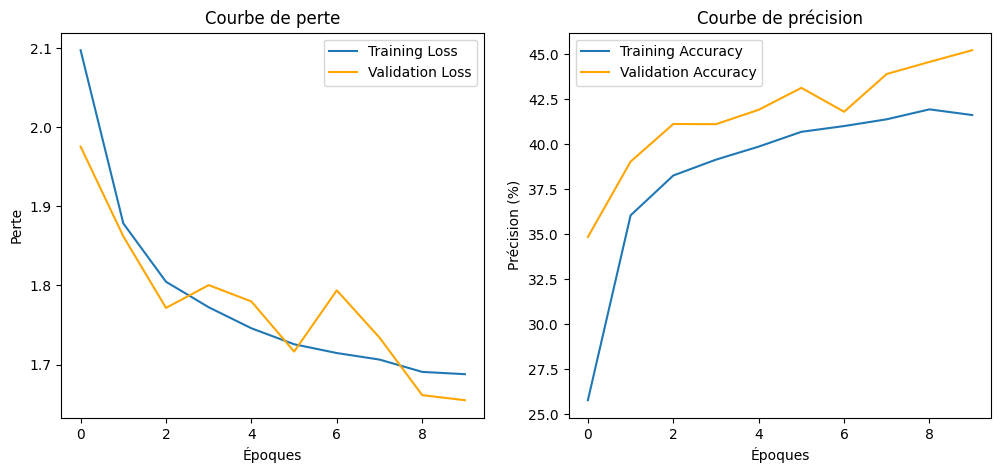

                           Model  Number of trainable params  Test accuracy  \
0  ResNet50 (Feature Extraction)                       20490          45.22   

   Training time per epoch (s)  Total training time (s)  
0                    57.792006               577.920064  


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import pandas as pd

# Vérification du dispositif disponible
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS (Metal Performance Shaders) trouvé et utilisé.")
else:
    print("MPS non disponible, le script se termine.")
    exit()

# Charger ResNet50 pré-entraîné et préparer pour l'extraction de caractéristiques
resnet50 = torchvision.models.resnet50(pretrained=True)
for param in resnet50.parameters():
    param.requires_grad = False

# Modifier la couche finale pour qu'elle s'adapte aux classes CIFAR-10
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, 10)
resnet50 = resnet50.to(device)

# Préparer les données CIFAR-10 avec augmentation plus variée
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Définir les fonctions d'entraînement et d'évaluation
def train_model_with_evaluation(model, trainloader, testloader, criterion, optimizer, scheduler, device, epochs=40):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    training_times = []
    total_training_time = 0
    num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    for epoch in range(epochs):
        model.train()  # Assurez-vous que le modèle est en mode entraînement
        start_time = time.time()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        scheduler.step()

        avg_loss = running_loss / len(trainloader)
        train_losses.append(avg_loss)
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)
        print(f"Epoch {epoch+1}, Loss: {avg_loss}, Accuracy: {train_accuracy}%, Trainable Params: {num_trainable_params}")
        
        # Évaluer le modèle après chaque époque
        val_loss, val_accuracy = evaluate_model(model, testloader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        end_time = time.time()
        epoch_time = end_time - start_time
        total_training_time += epoch_time
        training_times.append(epoch_time)
        
        print(f'Time for epoch {epoch+1}: {epoch_time:.2f} seconds')

    print(f'Total training time: {total_training_time:.2f} seconds')
    return train_losses, val_losses, train_accuracies, val_accuracies, training_times, total_training_time, num_trainable_params

def evaluate_model(model, testloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_loss = running_loss / len(testloader)
    accuracy = 100 * correct / total
    print(f"Validation Loss: {avg_loss}, Validation Accuracy: {accuracy}%")
    return avg_loss, accuracy

# Entraîner et évaluer le modèle
criterion = nn.CrossEntropyLoss()

# Changer l'optimiseur à Adam
optimizer = optim.Adam(resnet50.fc.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=00.1)

# Augmenter le nombre d'époques à 40
train_losses, val_losses, train_accuracies, val_accuracies, training_times, total_training_time, num_trainable_params = train_model_with_evaluation(resnet50, trainloader, testloader, criterion, optimizer, scheduler, device, epochs=10)

# Tracer les courbes de perte et de précision
plt.figure(figsize=(12, 5))

# Courbe de perte
plt.subplot(1, 2, 1)
plt.title("Courbe de perte")
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss", color='orange')
plt.xlabel("Époques")
plt.ylabel("Perte")
plt.legend()

# Courbe de précision
plt.subplot(1, 2, 2)
plt.title("Courbe de précision")
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy", color='orange')
plt.xlabel("Époques")
plt.ylabel("Précision (%)")
plt.legend()

plt.show()

# Afficher les résultats sous forme de tableaux
avg_train_time_per_epoch = total_training_time / len(training_times)
test_accuracy = val_accuracies[-1]

data = {
    "Model": ["ResNet50 (Feature Extraction)"],
    "Number of trainable params": [num_trainable_params],
    "Test accuracy": [test_accuracy],
    "Training time per epoch (s)": [avg_train_time_per_epoch],
    "Total training time (s)": [total_training_time]
}

df = pd.DataFrame(data)
print(df)

## feacture extraction vgg 16

MPS (Metal Performance Shaders) trouvé et utilisé.


/Users/usmanalfayed/miniforge3/envs/myenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/usmanalfayed/miniforge3/envs/myenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Loss: 1.838077350955485, Accuracy: 34.732%, Trainable Params: 40970
Validation Loss: 1.3632926952838897, Validation Accuracy: 52.37%
Time for epoch 1: 59.02 seconds
Epoch 2, Loss: 1.6190889238396569, Accuracy: 42.266%, Trainable Params: 40970
Validation Loss: 1.282074637413025, Validation Accuracy: 54.98%
Time for epoch 2: 58.07 seconds
Epoch 3, Loss: 1.5634610655972414, Accuracy: 44.456%, Trainable Params: 40970
Validation Loss: 1.245682929754257, Validation Accuracy: 56.15%
Time for epoch 3: 58.24 seconds
Epoch 4, Loss: 1.5287411185481665, Accuracy: 45.424%, Trainable Params: 40970
Validation Loss: 1.2274880278110505, Validation Accuracy: 56.96%
Time for epoch 4: 58.24 seconds
Epoch 5, Loss: 1.5072742996313382, Accuracy: 46.342%, Trainable Params: 40970
Validation Loss: 1.208325577378273, Validation Accuracy: 57.49%
Time for epoch 5: 58.37 seconds
Epoch 6, Loss: 1.490543203890476, Accuracy: 47.04%, T

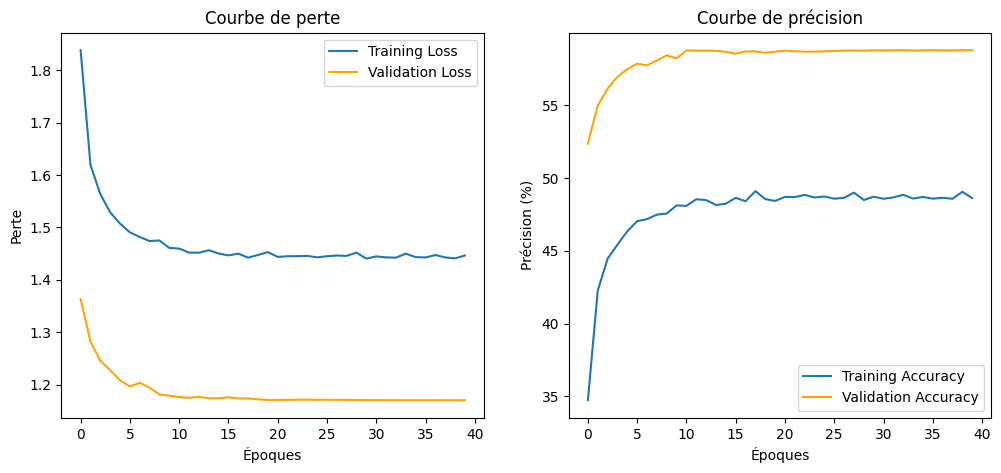

                        Model  Number of trainable params  Test accuracy  \
0  VGG16 (Feature Extraction)                       40970          58.79   

   Training time per epoch (s)  Total training time (s)  
0                    65.199299              2607.971945  


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import pandas as pd

# Vérification du dispositif disponible
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS (Metal Performance Shaders) trouvé et utilisé.")
else:
    print("MPS non disponible, le script se termine.")
    exit()

# Charger VGG16 pré-entraîné et préparer pour l'extraction de caractéristiques
vgg16 = torchvision.models.vgg16(pretrained=True)
for param in vgg16.parameters():
    param.requires_grad = False

# Modifier la couche finale pour qu'elle s'adapte aux classes CIFAR-10
num_ftrs = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(num_ftrs, 10)
vgg16 = vgg16.to(device)

# Préparer les données CIFAR-10 avec augmentation plus variée
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Définir les fonctions d'entraînement et d'évaluation
def train_model_with_evaluation(model, trainloader, testloader, criterion, optimizer, scheduler, device, epochs=40):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    training_times = []
    total_training_time = 0
    num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    for epoch in range(epochs):
        model.train()  # Assurez-vous que le modèle est en mode entraînement
        start_time = time.time()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        scheduler.step()

        avg_loss = running_loss / len(trainloader)
        train_losses.append(avg_loss)
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)
        print(f"Epoch {epoch+1}, Loss: {avg_loss}, Accuracy: {train_accuracy}%, Trainable Params: {num_trainable_params}")
        
        # Évaluer le modèle après chaque époque
        val_loss, val_accuracy = evaluate_model(model, testloader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        end_time = time.time()
        epoch_time = end_time - start_time
        total_training_time += epoch_time
        training_times.append(epoch_time)
        
        print(f'Time for epoch {epoch+1}: {epoch_time:.2f} seconds')

    print(f'Total training time: {total_training_time:.2f} seconds')
    return train_losses, val_losses, train_accuracies, val_accuracies, training_times, total_training_time, num_trainable_params

def evaluate_model(model, testloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_loss = running_loss / len(testloader)
    accuracy = 100 * correct / total
    print(f"Validation Loss: {avg_loss}, Validation Accuracy: {accuracy}%")
    return avg_loss, accuracy

# Entraîner et évaluer le modèle
criterion = nn.CrossEntropyLoss()

# Changer l'optimiseur à Adam
optimizer = optim.Adam(vgg16.classifier[6].parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Augmenter le nombre d'époques à 40
train_losses, val_losses, train_accuracies, val_accuracies, training_times, total_training_time, num_trainable_params = train_model_with_evaluation(vgg16, trainloader, testloader, criterion, optimizer, scheduler, device, epochs=40)

# Tracer les courbes de perte et de précision
plt.figure(figsize=(12, 5))

# Courbe de perte
plt.subplot(1, 2, 1)
plt.title("Courbe de perte")
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss", color='orange')
plt.xlabel("Époques")
plt.ylabel("Perte")
plt.legend()

# Courbe de précision
plt.subplot(1, 2, 2)
plt.title("Courbe de précision")
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy", color='orange')
plt.xlabel("Époques")
plt.ylabel("Précision (%)")
plt.legend()

plt.show()

# Afficher les résultats sous forme de tableaux
avg_train_time_per_epoch = total_training_time / len(training_times)
test_accuracy = val_accuracies[-1]

data = {
    "Model": ["VGG16 (Feature Extraction)"],
    "Number of trainable params": [num_trainable_params],
    "Test accuracy": [test_accuracy],
    "Training time per epoch (s)": [avg_train_time_per_epoch],
    "Total training time (s)": [total_training_time]
}

df = pd.DataFrame(data)
print(df)

## constat 